# Probabilistic retrieval model
Compare TfIdf vector space model with Okapi bm25 adding terms enrichment to queries.

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
import pymongo
from twitter import TwitterDataset, ENTITY, DOMAIN
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from string import punctuation

In [3]:
db = pymongo.MongoClient()['twitter']['tweets']
tdata = TwitterDataset(db)

In [4]:
stopw = set(stopwords.words('english'))
tokenizer = TweetTokenizer()
tokenize = lambda text: [word for word in tokenizer.tokenize(text.lower()) 
                         if word not in punctuation and word not in stopw and not word.startswith('http')] 

## Specificity score
$$
\delta(w) = p(w) \log \frac{p(w)}{q(w)}
$$

In [5]:
from collections import defaultdict

In [6]:
tweets = list(db.find())
G = defaultdict(lambda: 0)
Q = defaultdict(lambda: defaultdict(lambda: 0))

for tweet in tqdm(tweets):
    try:
        text = tweet['text']
        annotations = tweet['context_annotations']
        tokens = tokenize(text)
        for token in tokens:
            G[token] += 1
            for annotation in annotations:
                domain_name = annotation['domain']['name']
                Q[domain_name][token] += 1
                entity_name = annotation['entity']['name']
                Q[entity_name][token] += 1
    except KeyError:
        pass

  0%|          | 0/33053 [00:00<?, ?it/s]

In [7]:
def extend_query(query, top_k=5):
    Qtot = sum(Q[query].values())
    Gtot = sum(G.values())
    terms = {}
    for word, count in Q[query].items():
        p_w = count / Qtot
        q_w = G[word] / Gtot
        terms[word] = p_w * np.log(p_w / q_w)
    return [x for x, y in sorted(terms.items(), key=lambda x: -x[1])][:top_k]

## The Okapi bm25 system

In [8]:
from rank_bm25 import BM25Okapi

In [9]:
tokenized_corpus = [tokenize(text) for i, text in tdata.search_base]
bm25 = BM25Okapi(tokenized_corpus)

## The TfIdf IR system

In [10]:
from search import TfIdfSearchEngine

In [11]:
E = TfIdfSearchEngine(tdata.search_base, tokenize)

## Queries

In [12]:
def get_query_environment(query, query_type=ENTITY, top_k=5):
    ground_truth = tdata.ground_truth(query, query_type=query_type)
    extension = extend_query(query, top_k=top_k)
    return extension, ground_truth

In [13]:
entity_queries = ['Business & finance', 'COVID-19', 'Boris Johnson', 'Food']
domain_queries = ['Politician', 'TV Shows', 'Athlete', 'Sports Event']

## Evaluate

In [44]:
query = entity_queries[-1]
query_type = ENTITY
extension, ground_truth = get_query_environment(query, query_type=query_type, top_k=10)
y_true = [1 if i in ground_truth else 0 for i, _ in tdata.search_base]

In [45]:
print(extension, len(ground_truth))

['recipe', '#oldfashionedrecipes', '#recipe', 'cake', 'wine', '#cake', 'easy', 'cooking', 'simple', '#homemade'] 1584


In [46]:
tfidf_base = E.search(query)
tfidf_ext = E.search("{} {}".format(query, " ".join(extension)))

In [47]:
tfidf_base_scores = np.zeros(len(tdata.search_base))
for i, ti, score in tfidf_base:
    tfidf_base_scores[i] = score
tfidf_ext_scores = np.zeros(len(tdata.search_base))
for i, ti, score in tfidf_ext:
    tfidf_ext_scores[i] = score

In [48]:
okapi_base_scores = bm25.get_scores(tokenize(query))
okapi_ext_scores = bm25.get_scores(tokenize("{} {}".format(query, " ".join(extension))))

## Precision and recall curve

In [49]:
from sklearn.metrics import precision_recall_curve

In [50]:
import matplotlib.pyplot as plt

In [51]:
def plots(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    rec = list(sorted(recall, key=lambda x: x))
    prec = list(sorted(precision, key=lambda x: -x))
    iprec = [max(prec[i:]) for i in range(len(prec))]
    return rec, iprec

In [52]:
experiments = [
    ('TfIdf Base', tfidf_base_scores),
    ('TfIdf Ext', tfidf_ext_scores),
    ('Okapi Base', okapi_base_scores),
    ('Okapi Ext', okapi_ext_scores)
]

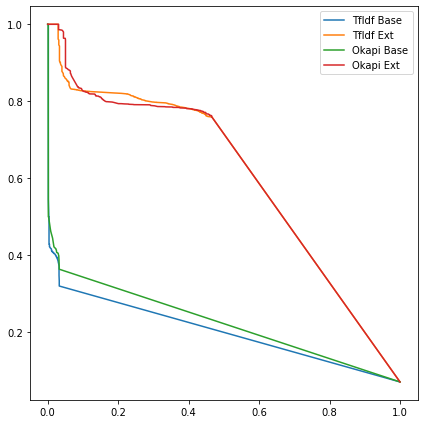

In [53]:
fig, ax = plt.subplots(figsize=(6, 6))
for elabel, escores in experiments:
    x, y = plots(y_true, escores)
    ax.plot(x, y, label=elabel)
plt.tight_layout()
plt.legend()
plt.show()